#Did the 3-Point Rule Affect Results in the German Fußball-Bundesliga?

**Author**: [Ramiro Gómez](http://ramiro.org/)

In this notebook we look at results from the German Fußball-Bundesliga using a dataset of [European football results](https://github.com/jalapic/engsoccerdata) compiled by [James Curley](https://jalapic.github.io/). Specifically we address the question whether the rule change from *2 points for a win* to *3 points for a win* had a visible effect on Bundesliga match results.

The question came up [in a Reddit discussion](https://www.reddit.com/r/dataisbeautiful/comments/3elbid/wintieloss_percentages_of_all_2015_english/ctghuuu) on [these nice visualisations](http://graphzoo.tumblr.com/day/2015/07/25) created by [Simon Garnier](http://www.simongarnier.org/) from the same data source for results in the English Premier League (EPL).

In the EPL it [does not look like](http://graphzoo.tumblr.com/post/124704781242/average-game-outcome-in-english-soccer-division-1) the rule change had much of an impact on the number of draws. What we can see is an increasing trend of home losses (away wins) for the past 4 decades, which started before the rule was introduced in 1981.

Let's now find out whether this is different in the German Bundesliga, where the winning team gets 3 points as of season 1995/96. At the time of writing the Bundesliga season 2014/15 was not included in the dataset.

In [1]:
%load_ext signature
%matplotlib inline

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import helpers

plt.style.use('ramiro')

df = pd.read_csv('csv/bundesliga.csv', parse_dates=['date'], encoding='latin-1')

chartinfo = 'Author: Ramiro Gómez - ramiro.org • Data: James Curley - github.com/jalapic/engsoccerdata'
infosize = 13

To get an idea of the information encoded in this data, let's look at the first few rows.

In [2]:
df.head()

,date,Season,home,visitor,FT,hgoal,vgoal,tier
0,1963-08-24,1963,Werder Bremen,Borussia Dortmund,3-2,3,2,1
1,1963-08-24,1963,1. FC Saarbrücken,1. FC Köln,0-2,0,2,1
2,1963-08-24,1963,TSV 1860 München,Eintracht Braunschweig,1-1,1,1,1
3,1963-08-24,1963,Frankfurter SG Eintracht,1. FC Kaiserslautern,1-1,1,1,1
4,1963-08-24,1963,FC Schalke 04,VfB Stuttgart,2-0,2,0,1


A data record corresponds to a single match and contains information on the match date, the year the football season started, the names of the home and visitor teams, the full-time result, the number of home and visitor goals and the tier, which in case of the Bundesliga is always 1.

To see some summary statistics we can use the `describe` method of [Pandas DataFrames](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [3]:
df.describe()

,Season,hgoal,vgoal,tier
count,15508.000000,15508.000000,15508.000000,15508
mean,1988.215115,1.872517,1.202863,1
std,14.591496,1.459254,1.162654,0
min,1963.000000,0.000000,0.000000,1
25%,1976.000000,1.000000,0.000000,1
50%,1988.000000,2.000000,1.000000,1
75%,2001.000000,3.000000,2.000000,1
max,2013.000000,12.000000,9.000000,1


The dataset contains 15508 records, the home team scores ~1.87 and the visitor team ~1.2 goals per game on average. The highest number of goals for a home team was 12 and for a visitor 9.

## Wins, losses and draws over time

To be able to compare wins, losses and draws over time, we first add a `resulttype` column so the data frame can be grouped by `Season` and `resulttype`. The grouped dataframe is then unstacked to yield a data structure suitable for the stacked bar plot we want to create.

In [4]:
def result(row):
    if row.hgoal > row.vgoal:
        return 'Home win'
    elif row.hgoal < row.vgoal:
        return 'Home loss'
    return 'Draw'

df['resulttype'] = df.apply(result, axis=1)
resulttypes_by_season = df.groupby(['Season', 'resulttype']).agg(['count'])['date']
df_rs = resulttypes_by_season.unstack()
df_rs.head()

count                   
resulttype  Draw Home loss Home win
Season                             
1963          61        53      126
1964          62        56      122
1965          68        70      168
1966          84        64      158
1967          73        66      167

Since the first 2 Bundesliga seasons had 16 teams and [season 1991/92](https://en.wikipedia.org/wiki/1991%E2%80%9392_Bundesliga) 20 teams as opposed to 18 in the remaining seasons, the number of matches is not the same in all seasons. So instead of total counts, we want to compare percentages of result types.

In [5]:
df_rs = df_rs.apply(lambda x: 100 * x / float(x.sum()), axis=1)
df_rs.head()

count                      
resulttype       Draw  Home loss   Home win
Season                                     
1963        25.416667  22.083333  52.500000
1964        25.833333  23.333333  50.833333
1965        22.222222  22.875817  54.901961
1966        27.450980  20.915033  51.633987
1967        23.856209  21.568627  54.575163

Bundesliga seasons start late in the summer of one year and end in the spring of the following year. So typically a season is displayed as *1995/96*, the `season_display` function does that. We also set some variables with the colors and data series to use and determine the minimum and maximum season values to show in the title.

In [6]:
def season_display(year):
    s = str(year)
    return '{0}/{1:02d}'.format(year, int(str(year + 1)[-2:]))

colors = ['#993300', '#003366', '#99cc99']
alpha = .7

c1, c2, c3 = df_rs['count'].columns
s1 = df_rs['count'][c1]
s2 = df_rs['count'][c2]
s3 = df_rs['count'][c3]

xmax = df_rs.index.max()
xmin = df_rs.index.min()

title = 'Wins, losses and draws in the Bundesliga seasons {} to {} in percent'.format(
    season_display(xmin), season_display(xmax))

The code in the following cell creates the actual graphic. We can use the [Pandas plot](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) function on the result types data frame, but want some more customization. Specifically the display of the season values as x-axis ticks and the legend.

The latter would be displayed above the bars, if we simply called `plot` with the keyword argument *legend=True*. To avoid that and place it below the chart we create a custom legend using [matplotlib Patch](http://matplotlib.org/api/patches_api.html#matplotlib.patches.Patch) objects.

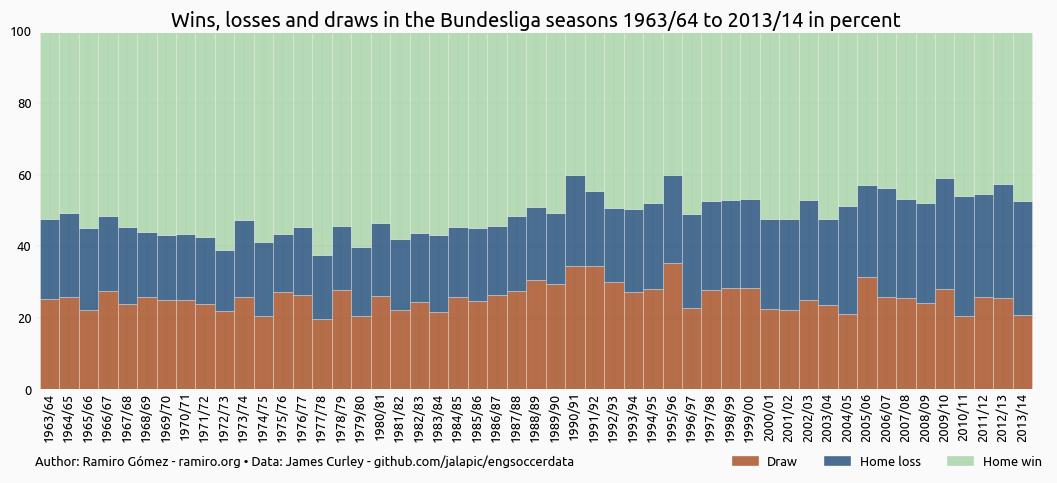

In [7]:
ax = df_rs.plot(kind='bar', stacked=True, figsize=(16, 6), color=colors, title=title, fontsize=13, width=1, alpha=alpha)
ax.set_ylim([0, 100])
ax.set_xlabel('', visible=False)
ax.xaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda val, p: season_display(df_rs.index[val])))

p1 = mpatches.Patch(color=colors[0], label=c1, alpha=alpha)
p2 = mpatches.Patch(color=colors[1], label=c2, alpha=alpha)
p3 = mpatches.Patch(color=colors[2], label=c3, alpha=alpha)

ax.legend(loc=(.69, -.23), handles=[p1, p2, p3], ncol=3, fontsize=13)
ax.annotate(chartinfo, xy=(0, -1.21), xycoords='axes fraction', fontsize=infosize)
plt.savefig('img/{}.png'.format(helpers.slug(title)), bbox_inches='tight')

One of the intentions of the 3 point rule was to increase the incentive of winning and thus reduce the number of draws. Ironically, season 1995/96, when the 3-point rule was introduced in Germany, has the highest percentage of draws in the displayed time frame. To be fair it decreased quite a bit the following year, but nothing suggests that the rule change had the desired impact.

## Most common results in the Bundesliga

One more thing we'll look at in this notebook are the most common full-time results. Again we'll compare results before and after the point rule change. First we create 2 separate data frames: `df_2points` contains the match records for 2 points for a win and `df_3points` the records 3 points for a win.

The series objects returned by the `value_counts` calls are then used to create a new data frame `df_results`. Same as before we want to use ratios instead of totals since the number of matches differs for the 2 series.

In [8]:
df_2points = df[df.Season < 1995]
df_3points = df[df.Season >= 1995]

results_2points = df_2points.FT.value_counts()
results_3points = df_3points.FT.value_counts()

df_results = pd.concat([
    results_2points / results_2points.sum(), 
    results_3points / results_3points.sum()], axis=1).fillna(0)

After setting a limit, the title, y-axis label and the column headings we add a sum column and sort it in descending order to show the 30 most common results across all years in the dataset.

In [9]:
limit = 30
title = '{} most common Bundesliga results: 2 vs 3 points for a win'.format(limit)
ylabel = 'Relative frequency of result'

cols = ['2 points for a win', '3 points for a win']
df_results.columns = cols

df_results['sum'] = df_results[cols[0]] + df_results[cols[1]]
df_results.sort('sum', inplace=True, ascending=False)

The remaining code creates a grouped bar plot for the most common match results. To make the results better readable and comprehensible the x-tick values are displayed horizontally and the y-ticks as percentages rather than ratios.

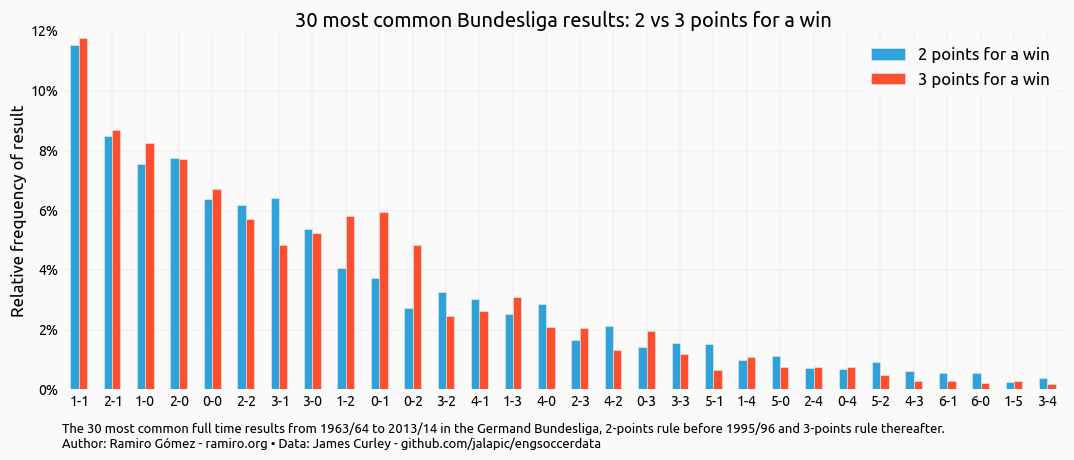

In [10]:
ax = df_results[cols].head(limit).plot(kind='bar', figsize=(16, 6), title=title)
ax.set_xticklabels(df_results.index[:limit], rotation=0)
ax.set_ylabel(ylabel)
ax.yaxis.set_major_formatter(
      mpl.ticker.FuncFormatter(lambda val, p: '{}%'.format(int(val*100))))

text = '''The 30 most common full time results from {} to {} in the Germand Bundesliga, 2-points rule before 1995/96 and 3-points rule thereafter.
{}'''.format(season_display(xmin), season_display(xmax), chartinfo)
ax.annotate(text, xy=(0, -1.16), xycoords='axes fraction', fontsize=infosize)
plt.savefig('img/{}.png'.format(helpers.slug(title)), bbox_inches='tight')

The 3 results that stand out most prominently are all home losses, whereas we do not see big differences in draws. This matches the impression of the first chart, i. e. there is no clear decrease in the number of draws after the point rule change.

Similar to the EPL the trend towards fewer home wins has started before the 3-point rule was introduced. While there could be a positive impact here, I assume this is rather due to football having become more professional and more of a business in that time frame and the teams have assimilated regarding their strengths.

I'll leave it at that for now, but intend to explore this dataset further in future notebooks. To be informed of new posts you can subscribe to the [notebooks RSS feed](http://ramiro.org/notebook/rss.xml).

In [11]:
signature